# 5.1-5.2 オフ方策学習における学習曲線

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data
from policylearners import RegBasedPolicyLearner, GradientBasedPolicyLearner, POTEC

### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの回帰ベース・勾配ベース・POTECの学習曲線の変化

In [2]:
## シミュレーション設定
num_runs = 100 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 500 # 行動数, |A|
num_clusters = 50 # 行動クラスタ数, |C|
lambda_ = 0.5 # クラスタ効果と残差効果の配合率
max_iter = 31 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_data_list = [100, 500, 2000] # トレーニングデータのサイズ

In [3]:
## 期待報酬関数を定義するためのパラメータを抽出
phi_a = random_.choice(num_clusters, size=num_actions)
theta_g = random_.normal(size=(dim_x, num_clusters))
M_g = random_.normal(size=(dim_x, num_clusters))
b_g = random_.normal(size=(1, num_clusters))
theta_h = random_.normal(size=(dim_x, num_actions))
M_h = random_.normal(size=(dim_x, num_actions))
b_h = random_.normal(size=(1, num_actions))

## 学習された方策の真の性能を近似するためのテストデータを生成
test_data = generate_synthetic_data(
    num_data=test_data_size, lambda_=lambda_,
    theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
    dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters, random_state = random_state
)
pi_0_value = (test_data["q_x_a"] * test_data["pi_0"]).sum(1).mean()

curve_list_data = []
for num_data in num_data_list:
    curve = DataFrame()
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters,
            random_state = _
        )

        log_ = DataFrame([
            [pi_0_value] * max_iter, ["logging"] * max_iter], index=["value", "method"]
        ).T.reset_index()

        ## ログデータを用いてオフ方策学習を実行する
        ### 回帰ベースのアプローチ
        reg = RegBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        reg.fit(offline_logged_data, test_data)
        reg_ = DataFrame([reg.test_value, ["reg"] * max_iter], index=["value", "method"]).T.reset_index()
        ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
        ips = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        ips.fit(offline_logged_data, test_data)
        ips_ = DataFrame([ips.test_value, ["ips"] * max_iter], index=["value", "method"]).T.reset_index()
        ### 勾配ベースのアプローチ (DR推定量で方策勾配を推定)
        dr = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, gamma=0.925, max_iter=max_iter)
        q_hat = offline_logged_data["q_x_a"] + random_.normal(scale=1/2, size=(num_data, num_actions))
        dr.fit(offline_logged_data, test_data, q_hat=q_hat)
        dr_ = DataFrame([dr.test_value, ["dr"] * max_iter], index=["value", "method"]).T.reset_index()
        ### POTECアルゴリズム
        potec = POTEC(dim_x=dim_x, num_actions=num_actions, num_clusters=num_clusters, max_iter=max_iter)
        f_hat = offline_logged_data["h_x_a"] + random_.normal(scale=1/2, size=(num_data, num_actions))
        f_hat_test = test_data["h_x_a"] + random_.normal(scale=1/2, size=test_data["h_x_a"].shape)
        potec.fit(offline_logged_data, test_data, f_hat=f_hat, f_hat_test=f_hat_test)
        potec_ = DataFrame([potec.test_value, ["potec"] * max_iter], index=["value", "method"]).T.reset_index()

        curve = pd.concat([curve, pd.concat([log_, reg_, ips_, dr_, potec_])])
    curve.reset_index(inplace=True)
    curve_list_data.append(curve)


num_data=2000...: 100%|██████████| 100/100 [1:22:17<00:00, 49.38s/it]


## 図5.5

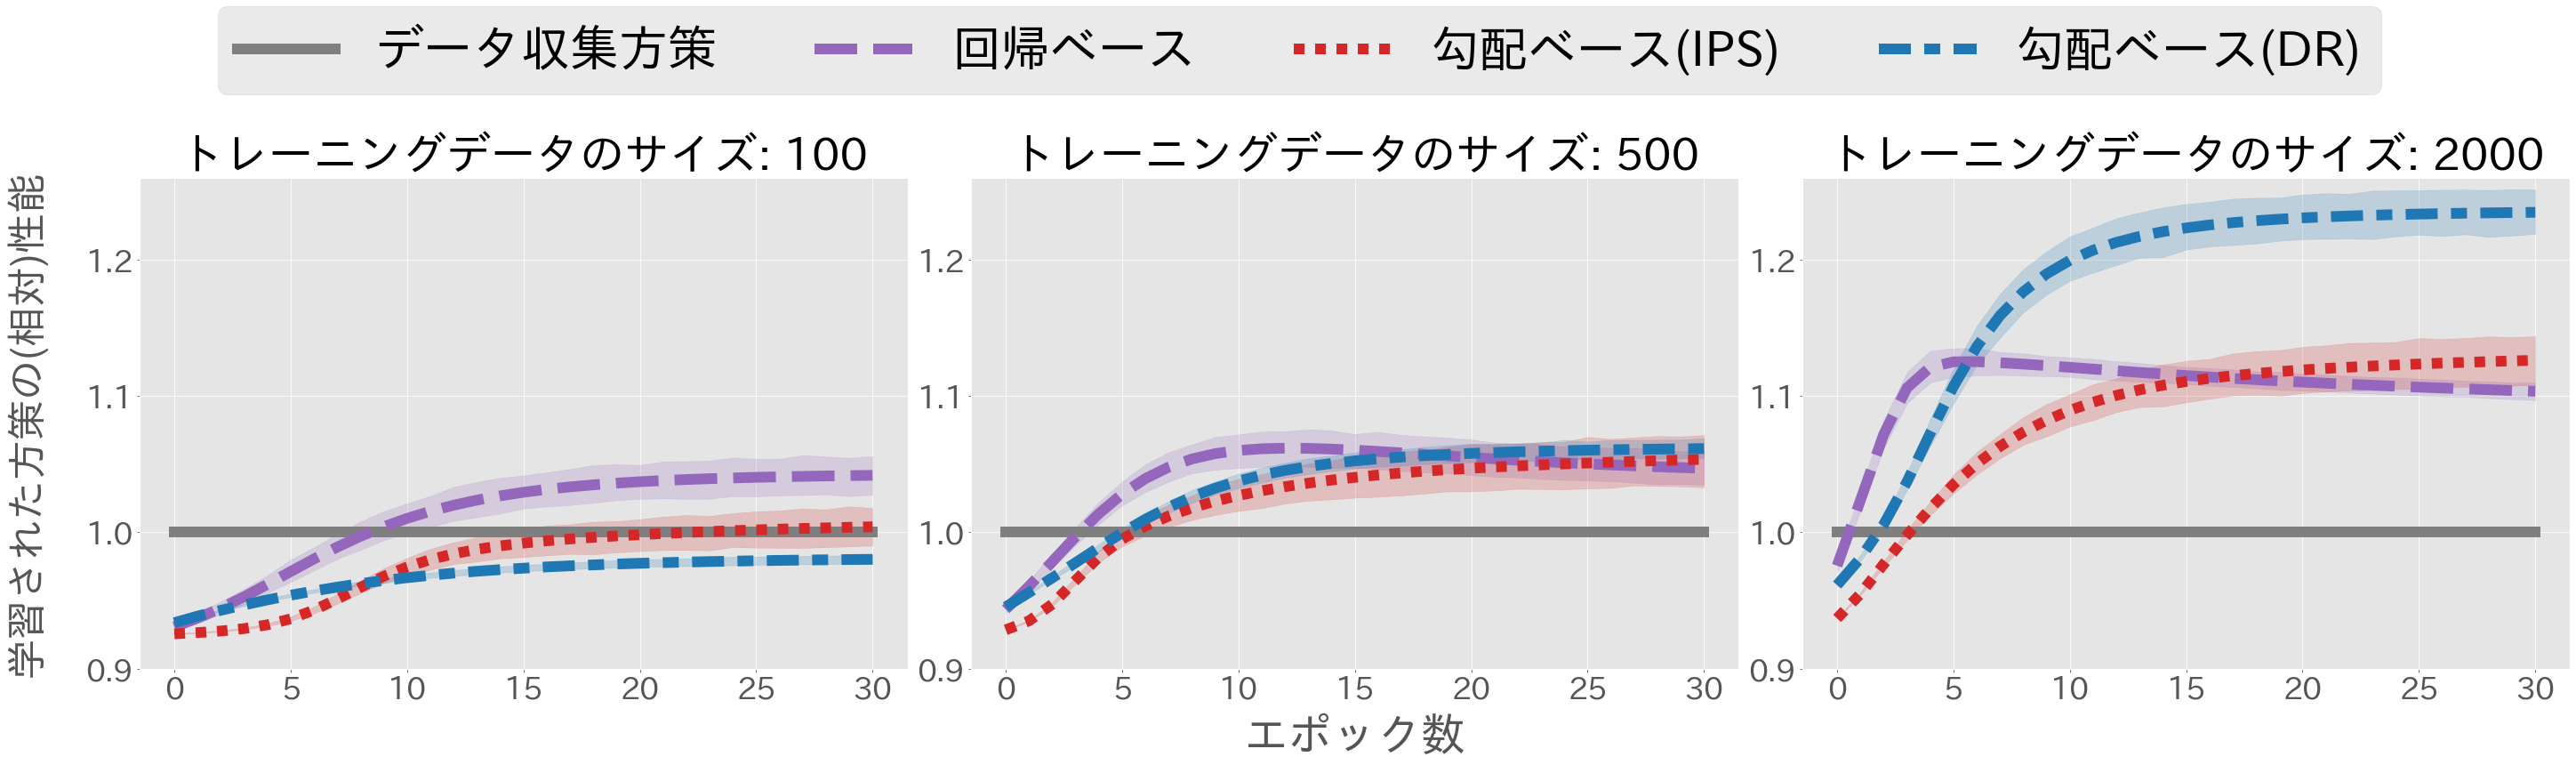

In [4]:
fig, ax_list = plt.subplots(1, 3, figsize=(40, 10), tight_layout=True)
for i, (num_data, curve) in enumerate(zip(num_data_list, curve_list_data)):
    curve["rel_value"] = curve.value / pi_0_value
    ax = ax_list[i]
    sns.lineplot(
        linewidth=12,
        x="index",
        y="rel_value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:purple", "tab:red", "tab:blue"],
        legend=False,
        data=curve.query("method != 'potec'"),
    )
    ax.set_title(f"トレーニングデータのサイズ: {num_data}", fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の(相対)性能", fontsize=45)
    else:
        ax.set_ylabel("", fontsize=45)
    ax.set_ylim(0.9, 1.26)
    ax.tick_params(axis="y", labelsize=35)
    ax.yaxis.set_label_coords(-0.12, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel("エポック数", fontsize=50)
    else:
        ax.set_xlabel("", fontsize=50)
    ax.tick_params(axis="x", labelsize=35)
    ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["データ収集方策", "回帰ベース", "勾配ベース(IPS)", "勾配ベース(DR)"], fontsize=55,
    bbox_to_anchor=(0.5, 1.12), ncol=5, loc="center",
)


## 図5.10

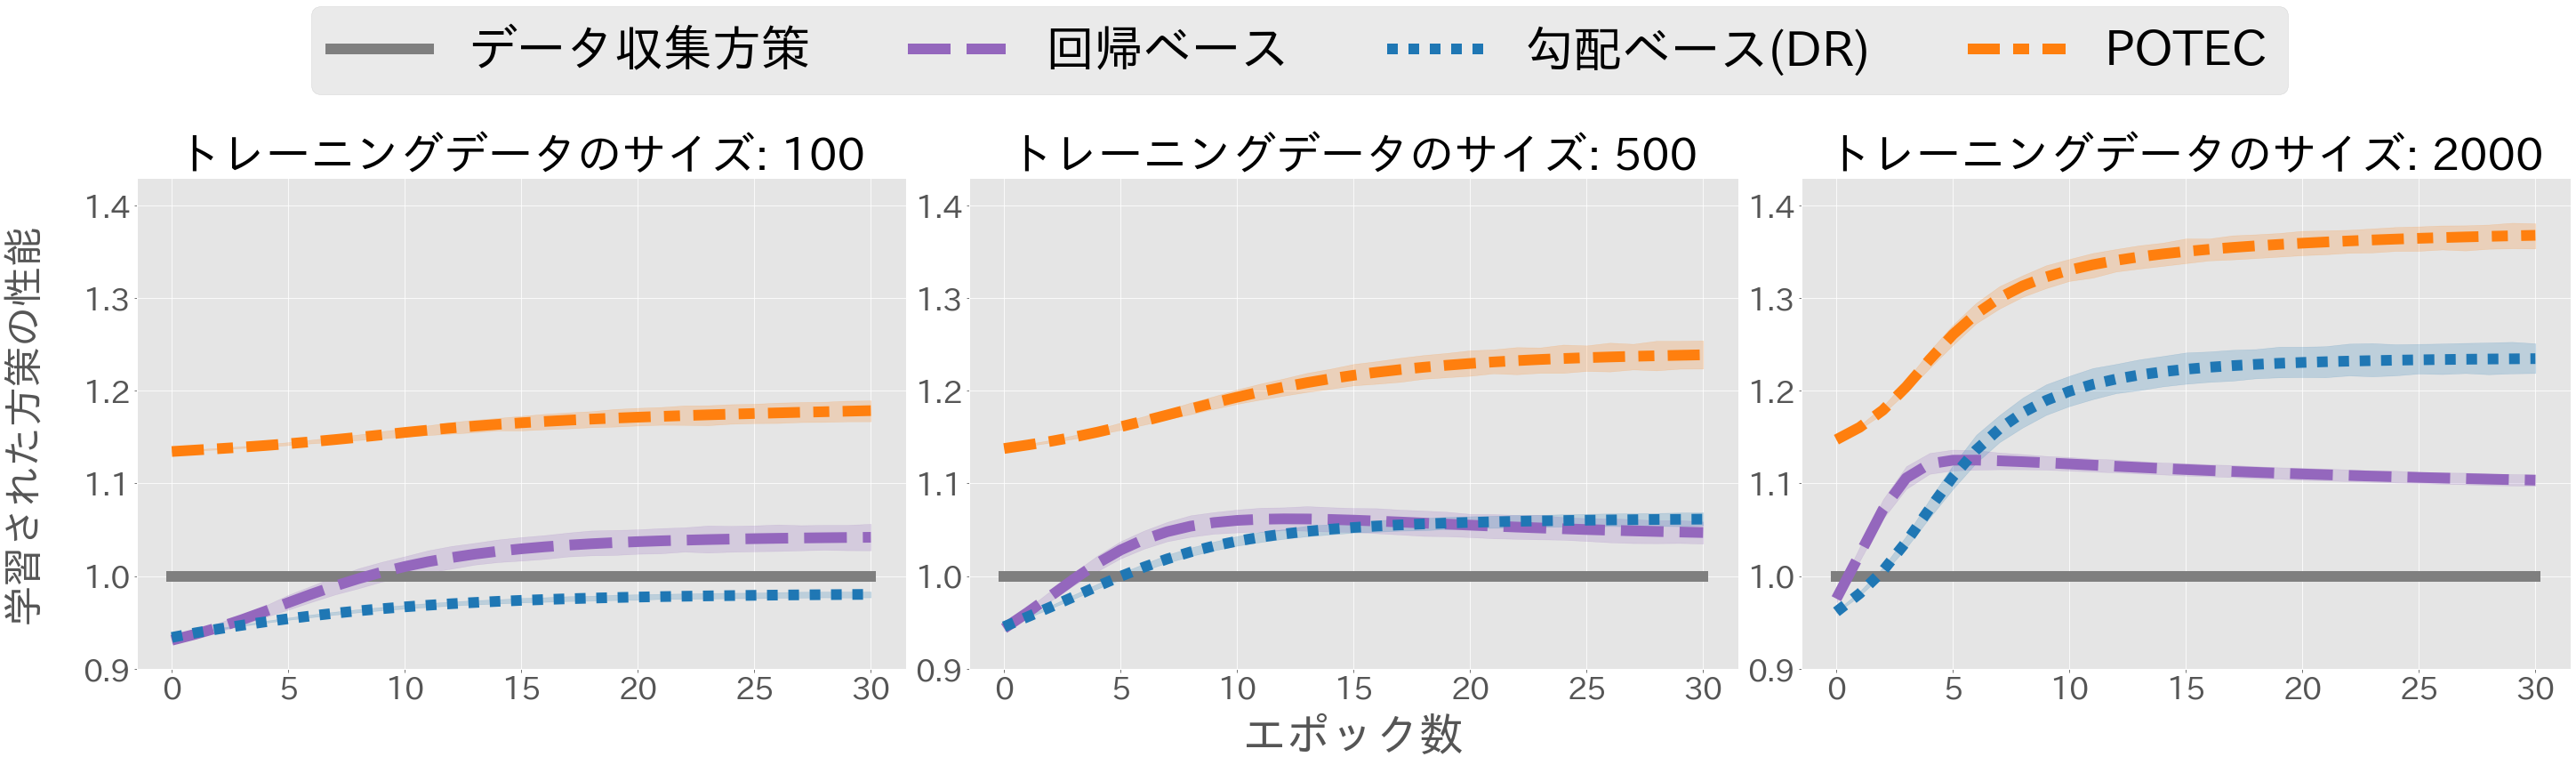

In [5]:
fig, ax_list = plt.subplots(1, 3, figsize=(40, 10), tight_layout=True)
for i, (num_data, curve) in enumerate(zip(num_data_list, curve_list_data)):
    curve["rel_value"] = curve.value / pi_0_value
    ax = ax_list[i]
    sns.lineplot(
        linewidth=12,
        x="index",
        y="rel_value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:purple", "tab:blue", "tab:orange"],
        legend=False,
        data=curve.query("method != 'ips'"),
    )
    ax.set_title(f"トレーニングデータのサイズ: {num_data}", fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=45)
    else:
        ax.set_ylabel("", fontsize=45)
    ax.set_ylim(0.9, 1.43)
    ax.tick_params(axis="y", labelsize=35)
    ax.yaxis.set_label_coords(-0.12, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel("エポック数", fontsize=50)
    else:
        ax.set_xlabel("", fontsize=50)
    ax.tick_params(axis="x", labelsize=35)
    ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["データ収集方策", "回帰ベース", "勾配ベース(DR)", "POTEC"], fontsize=55,
    bbox_to_anchor=(0.5, 1.12), ncol=5, loc="center",
)
